In [1]:
# Papermill params
ratio = 0.9          # Train-Test split ratio
n_iter = 100         # Number of times to run
epsilon = 1e-7
n_runs = 3

# Neural network

In this notebook we set up the neural networks with VAMPNet scoring functions and train them for different output sizes and estimate errors by bootstrap aggregation. This notebook can be used with `papermill` to run all cells automatically with given parameters. We first define the imports and useful utility functions.

In [53]:
%run model.py

<Figure size 432x288 with 0 Axes>

In [3]:
import traceback
def statdist(X: np.ndarray) -> np.ndarray:
    """
    Calculate the equilibrium distribution of a transition matrix.
    
    Parameters
    ----------
    X
        Row-stochastic transition matrix
    
    Returns
    -------
    mu
        Stationary distribution, i.e. the left
        eigenvector associated with eigenvalue 1.
    
    """
    ev, evec = eig(X, left=True, right=False)
    mu = evec.T[ev.argmax()]
    mu /= mu.sum()
    return mu

In [4]:
def test_split(data: MaybeListType[np.ndarray], lag: int, p: float=0.1):
    data = make_list(data)
    lengths = np.array([len(d) for d in data])
    nframes = lengths.sum()
    
    inds = np.empty((nframes, 3), dtype=np.int)
    inds[:, 0] = np.repeat(np.arange(len(data), dtype=np.int), lengths)
    inds[:, 1] = np.concatenate([np.arange(n) for n in lengths])
    inds[:, 2] = np.arange(nframes, dtype=np.int)
    inds = unflatten(inds, lengths=[lengths])
    
    # Local (frame) shuffling
    shuf_traj_inds = [np.random.choice(
        d[:, 1], size=d.shape[FRAMES], replace=False) for d in inds]
    
    # Sort out too short trajectories, split out lagged part
    n_pairs = 0
    xt, xttau = [], []
    for i, traj in enumerate(inds):
        n_points = traj.shape[FRAMES]

        # We'll just skip super short trajectories for now
        shuf_traj_inds[i] = shuf_traj_inds[i][shuf_traj_inds[i] < (n_points - lag)]
        if n_points <= lag:
            continue
                
        n_pairs += n_points - lag
        xt.append(traj[:n_points - lag][shuf_traj_inds[i]])
        xttau.append(traj[lag:n_points][shuf_traj_inds[i]])
        
    # Shuffle externally
    shuf_full_inds = np.random.choice(
        np.arange(n_pairs, dtype=np.int), size=n_pairs, replace=False)
    xt_shuf = np.vstack(xt)[shuf_full_inds]
    xttau_shuf = np.vstack(xttau)[shuf_full_inds]
    
    # These are the entries for the test set
    inds_t = xt_shuf[:int(xt_shuf.shape[FRAMES] * p)]
    inds_ttau = xttau_shuf[:int(xt_shuf.shape[FRAMES] * p)]
    data_flat = np.vstack(data)
    test_xt, test_xttau = data_flat[inds_t[:, 2]], data_flat[inds_ttau[:, 2]]
    
    # We can't just remove our test frame pairs, as the training set
    # would then be out of sync! So we replace the test samples with
    # NaNs instead, we can check for those later in the DataGenerator.
    data_flat[np.union1d(inds_t[:, 2], inds_ttau[:, 2])] = np.nan
    data_train_valid = unflatten(data_flat, lengths=[lengths])
        
    return data_train_valid, (test_xt, test_xttau)

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rc, ticker
from matplotlib.colors import ListedColormap
import seaborn as sns

import random
from collections import OrderedDict
from pathlib import Path

# Plot settings
sns.set_palette("husl", 8)
rc("font", **{"family": "Helvetica",
              "sans-serif": ["Helvetica"]})
rc("svg", **{"fonttype": "none"})
colors = sns.color_palette("husl", 8)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
def plot_its(its, lags, dt=1.0):
    multi = its.ndim == 3
    nits, nlags = its.shape[-2], its.shape[-1]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    
    if multi:
        itsm = its.mean(axis=0)
        cfl, cfu = np.percentile(its, q=(2.5, 97.5), axis=0)
    else:
        itsm = its
    
    ax.semilogy(lags * dt, lags * dt, color="k")
    ax.fill_between(lags * dt, ax.get_ylim()[0] * np.ones(len(lags)),
                    lags * dt, color="k", alpha=0.2)
    for i in range(nits):
        ax.plot(lags * dt, itsm[i], marker="o",
                    linestyle="dashed", linewidth=1.5, color=colors[-(i + 2)])
        ax.plot(lags * dt, itsm[i], marker="o", linewidth=1.5, color=colors[-(i + 2)])
        if multi:
            ax.fill_between(lags * dt, cfl[i], cfu[i],
                            interpolate=True, color=colors[-(i + 2)], alpha=0.2)
    loc = ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
    ax.set_ylim(1, 5000)
    ax.set_yticks(10 ** np.arange(5))
    ax.yaxis.set_minor_locator(loc)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.set_xlabel(r"$\tau$ [ns]", fontsize=24)
    ax.set_ylabel(r"$t_i$ [ns]", fontsize=24)
    ax.tick_params(labelsize=24)
    sns.despine(ax=ax)
    return fig

In [7]:
def plot_ck(cke, ckp, lag):
    multi = cke.ndim == 4
    n = cke.shape[-2]
    steps = cke.shape[-1]
    
    if multi:
        ckem = cke.mean(axis=0)
        ckpm = ckp.mean(axis=0)
        ckep = np.percentile(cke, q=(2.5, 97.5), axis=0)
        ckpp = np.percentile(ckp, q=(2.5, 97.5), axis=0)
    else:
        ckem = cke
        ckpm = ckp
    
    fig, axes = plt.subplots(n, n, figsize=(4 * n, 4 * n), sharex=True)
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            x = np.arange(0, steps * lag, lag)
            if multi:
                ax.errorbar(x, ckpm[i, j], yerr=[ckpm[i, j] - ckpp[0, i, j], ckpp[1, i, j] - ckpm[i, j]],
                            linewidth=2, elinewidth=2)
                ax.fill_between(x, ckep[0, i, j], ckep[1, i, j],
                                alpha=0.2, interpolate=True, color=colors[1])
            else:
                ax.plot(x, ckpm[i, j], linestyle="-", color=colors[0], linewidth=2)
            ax.plot(x, ckem[i, j], linestyle="--", color=colors[1], linewidth=2)
            
            if i == j:
                ax.set_ylim(0.78, 1.02)
                ax.text(0, 0.8, r"{0} $\to$ {1}".format(i, j), fontsize=24, verticalalignment="center")
            else:
                ax.set_ylim(-0.02, 0.22)
                ax.text(0, 0.2, r"{0} $\to$ {1}".format(i, j), fontsize=24, verticalalignment="center")
            ax.set_xticks(np.arange(0, steps * lag, lag), minor=True)
            ax.set_xticks(np.arange(0, steps * lag, 2 * lag))
            ax.set_xticklabels((np.arange(0, steps * lag, 2 * lag) * dt).astype(int))
            ax.tick_params(labelsize=24)
    fig.text(0.5, 0.01 * 1.5 * n, r"$\tau$ [ns]", ha="center", fontsize=24)
    fig.text(0.01 * 1.5 * n, 0.5, r"$P$", va="center", rotation="vertical", fontsize=24)
    fig.subplots_adjust(wspace=0.25)
    return fig

## Data
### Trajectories
Trajectories were acquired in multiple rounds of 1024 simulations each at 278 K in the $NVT$ ensemble yielding approximately 300 µs per ensemble. Postprocessing involved removing water, subsampling to 250 ps timesteps, and making molecules whole.

In [8]:
sim_names = ("apo", "holo", "control")
top, trajs = {}, {}
trajs = {k: sorted(glob("trajectories/{0}/r?/traj*.xtc".format(k))) for k in sim_names}
top = {k: "trajectories/{0}/topol.gro".format(k) for k in sim_names}
KBT = 2.311420 # 278 K
nres = 42
traj_rounds = {
    "apo": [1024, 1023, 1024, 1024, 1024],
    "holo": [1023, 1024, 32],
    "control": [1024, 1023]
}

We use minimum distances as features for the neural network:

In [9]:
allpairs = np.asarray(list(itertools.combinations(range(nres), 2)))
inpcon = {}
for k in sim_names:
    feat = pe.coordinates.featurizer(top[k])
    feat.add_residue_mindist(residue_pairs=allpairs)
    inpcon[k] = pe.coordinates.source(trajs[k], feat)

In [10]:
lengths, nframes = {}, {}
for i, k in enumerate(sim_names):
    lengths[k] = sort_lengths(inpcon[k].trajectory_lengths(), traj_rounds[k])
    nframes[k] = inpcon[k].trajectory_lengths().sum()

In [11]:
print("\t\t" + "\t\t".join(sim_names))
print("\n".join((
    "Trajs: \t\t" + "\t\t".join("{0}".format(len(trajs[k])) for k in sim_names),
    "Frames: \t" + "\t\t".join("{0}".format(nframes[k]) for k in sim_names),
    "Time: \t\t" + "\t".join("{0:5.3f} µs".format(inpcon[k].trajectory_lengths().sum() * 0.00025)
                           for k in sim_names)
)))

		apo		holo		control		phen
Trajs: 		5119		2079		2047		2048
Frames: 	1259172		1225868		1114503		1236792
Time: 		314.793 µs	306.467 µs	278.626 µs	309.198 µs


## VAMPNet
VAMPNet[1] is composed of two lobes, one reading the system features $\mathbf{x}$ at a timepoint $t$ and the other after some lag time $\tau$. In this case the network reads all minimum inter-residue distances (780 values) and sends them through 5 layers with 256 nodes each. The final layer uses between 2 and 8 *softmax* outputs to yield a state assignment vector $\chi: \mathbb{R}^m \to \Delta^{n}$ where $\Delta^{n} = \{ s \in \mathbb{R}^n \mid 0 \le s_i \le 1, \sum_i^n s_i = 1 \}$ representing the probability of a state assignment. One lobe thus transforms a system state into a state occupation probability. We can also view this value as a kind of reverse ambiguity, i.e. how sure the network is that the system is part of a certain cluster. These outputs are then used as the input for the VAMP scoring function. We use the new enhanced version with physical constraints[2], particularly the ones for positive entries and reversibility.

[1] Mardt, A., Pasquali, L., Wu, H. & Noé, F. VAMPnets for deep learning of molecular kinetics. Nat Comms 1–11 (2017). doi:10.1038/s41467-017-02388-1

[2] Mardt, A., Pasquali, L., Noé, F. & Wu, H. Deep learning Markov and Koopman models with physical constraints. arXiv:1912.07392 [physics] (2019).

### Data preparation
We use minimum residue distances as input ($\frac{N(N-1)}{2}$ values, where $N$ is the number of residues) and first normalize the data:

In [12]:
for k in sim_names:
    filename = "intermediate/mindist-all-{0}.npy".format(k)
    if not os.path.exists(filename):
        print("No mindist file for {0} ensemble, calculating from scratch...".format(k))
        con = np.vstack(inpcon[k].get_output())
        np.save(filename, con)

In [13]:
idx = np.triu_indices(nres, k=1)
mat = np.zeros((nres, nres), dtype=np.int)
full_flat, full_data = {}, {}
for k in sim_names:
    raw = np.load("intermediate/mindist-all-{0}.npy".format(k))
    mat[idx] = np.arange(raw.shape[1])
    redinds = mat[np.triu_indices_from(mat, k=3)]
    full_flat[k] = ((raw - raw.mean(axis=0)) / raw.std(axis=0))[:, redinds]
    full_data[k] = unflatten(full_flat[k], lengths[k])

### Neural network hyperparameters
To allow for a larger hyperparameter search space, we use the self-normalizing neural network approach by Klambauer *et al.* [2], thus using SELU units, `AlphaDropout` and normalized `LeCun` weight initialization. The other hyperparameters are defined at the beginning of this notebook.

[2] Klambauer, G., Unterthiner, T., Mayr, A. & Hochreiter, S. Self-Normalizing Neural Networks. arXiv.org cs.LG, (2017).

In [67]:
activation = "selu"                 # NN activation function
init = "lecun_normal"               # NN weight initialization
lag = 20                            # Lag time
n_epoch = 100                       # Max. number of epochs
n_epoch_s = 10000                   # Max. number of epochs for S optimization
n_batch = 10000                     # Training batch size
n_dims = full_data[k][0].shape[1]  # Input dimension
nres = 42                           # Number of residues
epsilon = 1e-7                      # Floating point noise
dt = 0.25                           # Trajectory timestep in ns
steps = 6                           # CK test steps
bs_frames = 1000000                 # Number of frames in the bootstrap sample
n_tries = 3                         # Number of training attempts for each model, we pick the best scoring one

outsizes = np.array([4, 2, 3, 5, 6])
lags = np.array([1, 2, 5, 10, 20, 50, 100])

In [15]:
input_data, input_flat, test_data = {}, {}, {}
for k in ("holo", "control"):
    filename = "intermediate/input-{0}.npz".format(k)
    if not os.path.exists(filename):
        print("No input file for {0} ensemble, resplitting...".format(k))
        input_data[k], test_data[k] = test_split(full_data[k], lag=lag)
        input_flat[k] = np.vstack(input_data[k])
        np.savez(filename, data=input_flat[k], test_t=test_data[k][0], test_ttau=test_data[k][1])
    else:
        print("Reading existing input file for {0} ensemble...".format(k))
        raw = np.load(filename)
        input_flat[k], test_data[k] = raw["data"], (raw["test_t"], raw["test_ttau"])
        input_data[k] = unflatten(input_flat[k], lengths=lengths[k])

Reading existing input file for holo ensemble...
Reading existing input file for control ensemble...
Reading existing input file for phen ensemble...


In [68]:
global_space = OrderedDict(
    depth=[3, 4, 5],
    width=[256, 512, 768],
    learning_rate=[5e-2, 1e-2],
    regularization=[1e-5, 1e-6, 1e-7],
    dropout=[0.0],
    lr_factor=[5e-3]
)

In [63]:
def test_model(space):
    generator = DataGenerator(input_data[k], dt=dt, max_frames=500000)
    tests = test_data[k], np.zeros((test_data[k][0].shape[0], 2 * n))
    its = np.empty((n_runs, n - 1, len(lags)))
    scores = np.empty(n_runs)
    for i in range(n_runs):
        try:
            koop = KoopmanModel(n=n, network_lag=lag, verbose=1, nnargs=dict(
                width=space["width"], depth=space["depth"], learning_rate=space["learning_rate"],
                regularization=space["regularization"], dropout=space["dropout"],
                batchnorm=False, lr_factor=space["lr_factor"]))
            koop.fit(generator)
            its[i] = koop.its(lags)
            scores[i] = koop.score(tests)
        except Exception as e:
            print("ERROR")
            traceback.print_exc()
            print()
        finally:
            generator.regenerate_indices()
            del koop
            gc.collect()
    return its, scores

In [21]:
def to_number(val):
    return float(val) if "." in val or "e" in val else int(val)

EVAL BEGIN
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
Parameters:
  lr_factor: 		0.005
  width: 		128
  regularization: 		1e-10
  depth: 		2
  learning_rate: 		0.01
  dropout: 		0.0

Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 4s 8us/sample - loss: -5.9677e-05 - metric_VAMP: 2.3882 - val_loss: -6.0604e-05 - val_metric_VAMP: 2.4253
Epoch 2/100
450000/450000 [==============================] - 2s 5us/sample - loss: -6.0924e-05 - metric_VAMP: 2.4381 - val_loss: -6.1216e-05 - val_metric_VAMP: 2.4497
Epoch 3/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1147e-05 - metric_VAMP: 2.4470 - val_loss: -6.1160e-05 - val_metric_VAMP: 2.4475
Epoch 4/100
450000/450000 [==============================] - 2s 6us/sample - loss: -6.0997e-05 - metric_VAMP: 2.4410 - val_loss: -6.0982e-05 - val_metric_VAMP: 2.4404
Epoch 5/100
450000/450000 [==============================] -

Epoch 97/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.3967e-05 - metric_VAMP: 2.5680 - val_loss: -6.3903e-05 - val_metric_VAMP: 2.5572
Epoch 98/100
450000/450000 [==============================] - 2s 6us/sample - loss: -6.4028e-05 - metric_VAMP: 2.5719 - val_loss: -6.3916e-05 - val_metric_VAMP: 2.5577
Epoch 99/100
450000/450000 [==============================] - 2s 6us/sample - loss: -6.3625e-05 - metric_VAMP: 2.5589 - val_loss: -6.3931e-05 - val_metric_VAMP: 2.5584
Epoch 100/100
450000/450000 [==============================] - 2s 5us/sample - loss: -6.3944e-05 - metric_VAMP: 2.5597 - val_loss: -6.3949e-05 - val_metric_VAMP: 2.5591
Train on 450000 samples, validate on 50000 samples
Epoch 1/100
450000/450000 [==============================] - 4s 8us/sample - loss: -2.2737 - metric_VAMP: 2.6112 - val_loss: -2.3665 - val_metric_VAMP: 2.6643
Epoch 2/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.4453 - metric_VAMP: 2.7083 - va

Epoch 48/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8711 - metric_VAMP: 2.9348 - val_loss: -2.8550 - val_metric_VAMP: 2.9266
Epoch 49/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8727 - metric_VAMP: 2.9356 - val_loss: -2.8561 - val_metric_VAMP: 2.9272
Epoch 50/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8744 - metric_VAMP: 2.9365 - val_loss: -2.8587 - val_metric_VAMP: 2.9285
Epoch 51/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8762 - metric_VAMP: 2.9375 - val_loss: -2.8600 - val_metric_VAMP: 2.9291
Epoch 52/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8779 - metric_VAMP: 2.9383 - val_loss: -2.8610 - val_metric_VAMP: 2.9297
Epoch 53/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.8793 - metric_VAMP: 2.9390 - val_loss: -2.8628 - val_metric_VAMP: 2.9306
Epoch 54/100
450000/450000 [============

450000/450000 [==============================] - 2s 5us/sample - loss: -3.9288 - val_loss: -3.8914
Epoch 69/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9291 - val_loss: -3.8915
Epoch 70/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9292 - val_loss: -3.8907
Epoch 71/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9295 - val_loss: -3.8916
Epoch 72/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9298 - val_loss: -3.8921
Epoch 73/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9300 - val_loss: -3.8916
Epoch 74/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9303 - val_loss: -3.8915
Epoch 75/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9307 - val_loss: -3.8918
Epoch 76/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9309 - val_los

450000/450000 [==============================] - 2s 5us/sample - loss: -3.9436 - val_loss: -3.8939
Epoch 12/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9436 - val_loss: -3.8939
Epoch 13/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9438 - val_loss: -3.8938
Epoch 14/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9439 - val_loss: -3.8936
Epoch 15/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9441 - val_loss: -3.8938
Epoch 16/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9441 - val_loss: -3.8939
Epoch 17/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9442 - val_loss: -3.8936
Epoch 18/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9442 - val_loss: -3.8939
Epoch 19/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9443 - val_los

450000/450000 [==============================] - 2s 5us/sample - loss: -3.9470 - val_loss: -3.8933
Epoch 34/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9471 - val_loss: -3.8930
Epoch 35/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9472 - val_loss: -3.8931
Epoch 36/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9472 - val_loss: -3.8928
Epoch 37/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9474 - val_loss: -3.8930
Epoch 38/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9474 - val_loss: -3.8936
Epoch 39/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9474 - val_loss: -3.8930
Epoch 40/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9474 - val_loss: -3.8924
Epoch 41/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9475 - val_los

450000/450000 [==============================] - 3s 6us/sample - loss: -6.2793e-05 - metric_VAMP: 2.5169 - val_loss: -6.2781e-05 - val_metric_VAMP: 2.5123
Epoch 42/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.2823e-05 - metric_VAMP: 2.5140 - val_loss: -6.2806e-05 - val_metric_VAMP: 2.5133
Epoch 43/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.2853e-05 - metric_VAMP: 2.5152 - val_loss: -6.2828e-05 - val_metric_VAMP: 2.5142
Epoch 44/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.2881e-05 - metric_VAMP: 2.5164 - val_loss: -6.2852e-05 - val_metric_VAMP: 2.5152
Epoch 45/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.2909e-05 - metric_VAMP: 2.5175 - val_loss: -6.2878e-05 - val_metric_VAMP: 2.5162
Epoch 46/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.2940e-05 - metric_VAMP: 2.5187 - val_loss: -6.2902e-05 - val_metric_VAMP: 2.5172
Epoch

Epoch 90/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.3931e-05 - metric_VAMP: 2.5582 - val_loss: -6.3832e-05 - val_metric_VAMP: 2.5543
Epoch 91/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.3898e-05 - metric_VAMP: 2.5588 - val_loss: -6.4704e-05 - val_metric_VAMP: 2.5549
Epoch 92/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.3999e-05 - metric_VAMP: 2.5595 - val_loss: -6.3863e-05 - val_metric_VAMP: 2.5556
Epoch 93/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.4023e-05 - metric_VAMP: 2.5602 - val_loss: -6.3877e-05 - val_metric_VAMP: 2.5562
Epoch 94/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.3898e-05 - metric_VAMP: 2.5609 - val_loss: -6.3891e-05 - val_metric_VAMP: 2.5567
Epoch 95/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.4052e-05 - metric_VAMP: 2.5615 - val_loss: -6.3907e-05 - val_metric_VAMP:

450000/450000 [==============================] - 3s 6us/sample - loss: -2.9772 - metric_VAMP: 2.9886 - val_loss: -2.9514 - val_metric_VAMP: 2.9756
Epoch 92/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9774 - metric_VAMP: 2.9887 - val_loss: -2.9526 - val_metric_VAMP: 2.9762
Epoch 93/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9780 - metric_VAMP: 2.9890 - val_loss: -2.9523 - val_metric_VAMP: 2.9761
Epoch 94/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9781 - metric_VAMP: 2.9891 - val_loss: -2.9525 - val_metric_VAMP: 2.9761
Epoch 95/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9780 - metric_VAMP: 2.9890 - val_loss: -2.9529 - val_metric_VAMP: 2.9763
Epoch 96/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9785 - metric_VAMP: 2.9892 - val_loss: -2.9527 - val_metric_VAMP: 2.9763
Epoch 97/100
450000/450000 [=========================

Both valid loss: -3.9331746101379395
Train on 450000 samples, validate on 50000 samples
Epoch 1/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9762 - val_loss: -3.9457
Epoch 2/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9765 - val_loss: -3.9455
Epoch 3/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9765 - val_loss: -3.9456
Epoch 4/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9766 - val_loss: -3.9452
Epoch 5/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9767 - val_loss: -3.9455
Epoch 6/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9768 - val_loss: -3.9448
Epoch 7/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9770 - val_loss: -3.9455
Epoch 8/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9770 - val_loss: -3.9457
Epoch 9/

Epoch 7/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1957e-05 - metric_VAMP: 2.4794 - val_loss: -6.1838e-05 - val_metric_VAMP: 2.4746
Epoch 8/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1887e-05 - metric_VAMP: 2.4766 - val_loss: -6.1767e-05 - val_metric_VAMP: 2.4718
Epoch 9/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1829e-05 - metric_VAMP: 2.4743 - val_loss: -6.1722e-05 - val_metric_VAMP: 2.4700
Epoch 10/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1799e-05 - metric_VAMP: 2.4731 - val_loss: -6.1703e-05 - val_metric_VAMP: 2.4692
Epoch 11/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1784e-05 - metric_VAMP: 2.4725 - val_loss: -6.1704e-05 - val_metric_VAMP: 2.4693
Epoch 12/100
450000/450000 [==============================] - 3s 6us/sample - loss: -6.1789e-05 - metric_VAMP: 2.4727 - val_loss: -6.1726e-05 - val_metric_VAMP: 2.

450000/450000 [==============================] - 3s 6us/sample - loss: -2.9830 - metric_VAMP: 2.9915 - val_loss: -2.9628 - val_metric_VAMP: 2.9814
Epoch 86/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9831 - metric_VAMP: 2.9915 - val_loss: -2.9620 - val_metric_VAMP: 2.9809
Epoch 87/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9831 - metric_VAMP: 2.9915 - val_loss: -2.9623 - val_metric_VAMP: 2.9811
Epoch 88/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9833 - metric_VAMP: 2.9916 - val_loss: -2.9628 - val_metric_VAMP: 2.9813
Epoch 89/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9839 - metric_VAMP: 2.9919 - val_loss: -2.9627 - val_metric_VAMP: 2.9813
Epoch 90/100
450000/450000 [==============================] - 3s 6us/sample - loss: -2.9839 - metric_VAMP: 2.9920 - val_loss: -2.9632 - val_metric_VAMP: 2.9815
Epoch 91/100
450000/450000 [=========================

Epoch 37/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9826 - val_loss: -3.9517
Epoch 38/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9826 - val_loss: -3.9508
Epoch 39/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9828 - val_loss: -3.9511
Epoch 40/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9828 - val_loss: -3.9515
Epoch 41/10000
450000/450000 [==============================] - 2s 5us/sample - loss: -3.9829 - val_loss: -3.9508
Epoch 42/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9829 - val_loss: -3.9508
Epoch 43/10000
450000/450000 [==============================] - 2s 6us/sample - loss: -3.9829 - val_loss: -3.9505
Epoch 44/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3.9831 - val_loss: -3.9507
Epoch 45/10000
450000/450000 [==============================] - 3s 6us/sample - loss: -3

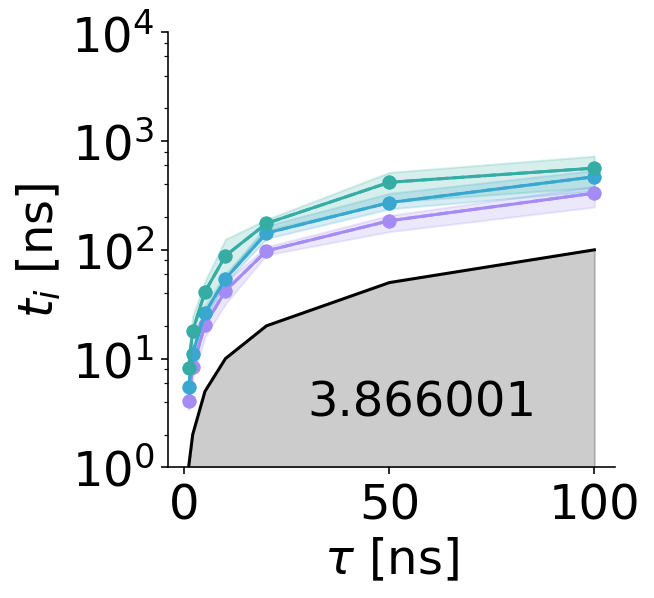

In [70]:
k, n = "holo", 4
history = [tuple(to_number(val) for val in f.stem.split("_")[1:])
           for f in Path("hp-figs").iterdir()]
for _ in range(n_iter):
    vals = OrderedDict((k, random.choice(v)) for k, v in global_space.items())
    if tuple(vals.values()) in history:
        continue
    history.append(tuple(vals.values()))
    print("EVAL BEGIN")
    print("=~" * 40)
    print("Parameters:")
    for key, val in vals.items():
        print("  {0}: \t\t{1}".format(key, val))
    print()
    its, scores = test_model(vals)
    
    print("EVAL COMPLETE")
    print("=~" * 40)
    print("Scores:")
    for score in scores:
        print("  {0:4.6f}".format(score))
    print()
    print("=~" * 40)
    
    fig = plot_its(its, lags)
    fig.axes[0].text(30, 3, "{0:4.6f}".format(np.nanmean(scores)), fontsize=24)
    fig.savefig("hp-figs/hp-{0}.png".format("_".join(str(v) for v in vals.values())),
                bbox_inches="tight", transparent=True)